In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
import sklearn.metrics.pairwise as metrics

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/sasha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
_models_path = '/Users/sasha/dev/mmuze/_models/InferSent'

In [20]:
# Load model
from models import InferSent
model_version = 2
MODEL_PATH = f'{_models_path}/encoder/infersent{model_version}.pkl' 
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

In [21]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = f'{_models_path}/dataset/GloVe/glove.840B.300d.txt' if model_version == 1 else 'dataset/fastText/crawl-300d-2M.vec'
model.set_w2v_path(W2V_PATH)

In [5]:
# Load embeddings of K most frequent words
model.build_vocab_k_words(K=1000000)

Vocab size : 1000000


In [6]:
sentences = ["jeans", "denim", "pants", "trousers",
            "package", "parcel", 
            "hot", "cold", 
            "I do not like you", "I love you",
            "The package didn't arrived, what happens with it", "I havn't received my order yet", "My tracking number doesn't work. Can you help?"]

In [7]:
# model.build_vocab(sentences, tokenize=True)

In [8]:
embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 61/64 (95.3%)
Speed : 47.1 sentences/s (cpu mode, bsize=128)
nb sentences encoded : 13


In [9]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [10]:
def plot_similarity(labels, corr): 
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=90)
  g.set_title("Semantic Textual Similarity")

In [11]:
import tensorflow as tf
def sim_exact_cross(embs1, embs2):
    input1 = tf.placeholder(tf.float64, shape=(None))
    input2 = tf.placeholder(tf.float64, shape=(None))

    norm1 = tf.nn.l2_normalize(input1, axis=1)
    norm2 = tf.nn.l2_normalize(input2, axis=1)
    cosine_similarities = tf.tensordot(norm1, norm2, axes=((1),(1)))
#     cosine_similarities = tf.reduce_sum(vectorsdot, axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    sim_scores = 1.0 - tf.acos(clip_cosine_similarities)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        session.run(tf.tables_initializer())
  
        norm1, norm2, scores, vectorsdot = session.run([norm1, norm2, sim_scores, cosine_similarities], 
                                         feed_dict={ input1: embs1,
                                                     input2: embs2 })
          
    return scores, emb1, emb2, cosine_similarities

In [12]:
cosine(embeddings[6], embeddings[6])

1.0000001

In [13]:
embs_combs = [(x,y) for x in embeddings for y in embeddings]


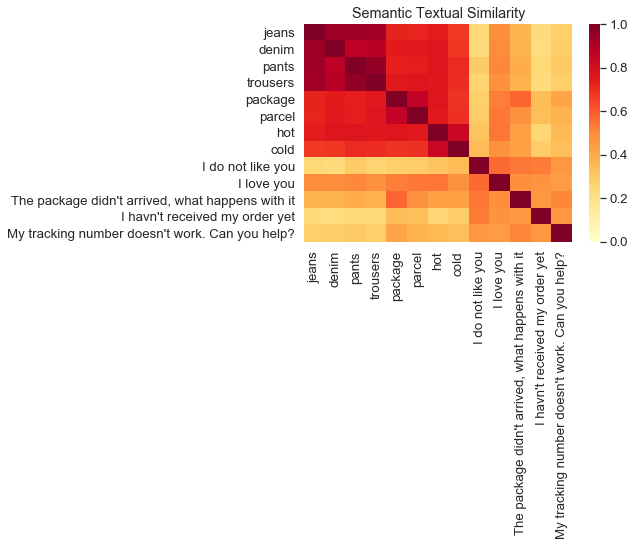

In [14]:
embds_comps_sims1 = np.array(list(map(lambda s1s2: cosine(s1s2[0],s1s2[1]), embs_combs))).reshape(int(np.sqrt(len(embs_combs))),int(np.sqrt(len(embs_combs))))
plot_similarity(sentences, embds_comps_sims1)

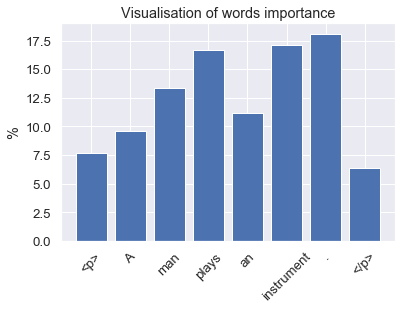

(tensor([[ 0.0075,  0.1772,  0.1542,  ..., -0.0334, -0.0174,  0.0108]],
        grad_fn=<MaxBackward0>), array([[0, 2, 5, ..., 2, 4, 5]]))

In [15]:
model.visualize('A man plays an instrument.', tokenize=True)